In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.set_option('display.max_columns',None)

pd.set_option('display.max_colwidth',1000)

%matplotlib inline

In [2]:
#pull in data from the mongo database on the AWS machine
import pymongo

client = pymongo.MongoClient('mongodb://34.235.163.2/example') # defaults to port 27017
db = client.example
articlesdb = db.NYT_articles


In [3]:

#you can only run the below cell if the aws is connected and mongo is turned on, otherwise pick up from the pickle file below
df=pd.DataFrame(list(articlesdb.find()))


# with open("df_Final_NYTarticles", 'rb') as picklefile: 
#     df = pickle.load(picklefile)

## Cleaning and Simple EDA

In [906]:
# clear out all the articles that don't have any text
df =df[df['text'] != '']

In [907]:
#remove articles that aren't very entrenuership focused
import re

key_wds_remove = ['//boss.', 'morning-agenda']

remove_urls = []
for wd in key_wds_remove:
    for i in range(len(df)):
        try:
            if re.search(wd, df['web_url'][i]):
                remove_urls.append(df['web_url'][i])
        except:
            continue

df = df[~df['web_url'].isin(remove_urls)]

In [909]:
# fix data types

df['pub_date'] = df['pub_date'].astype('datetime64[D]')
df['year'] = df['pub_date'].dt.year

df = df.reset_index().drop('index', axis = 1)

Text(0.5,1,'Distribution of Articles')

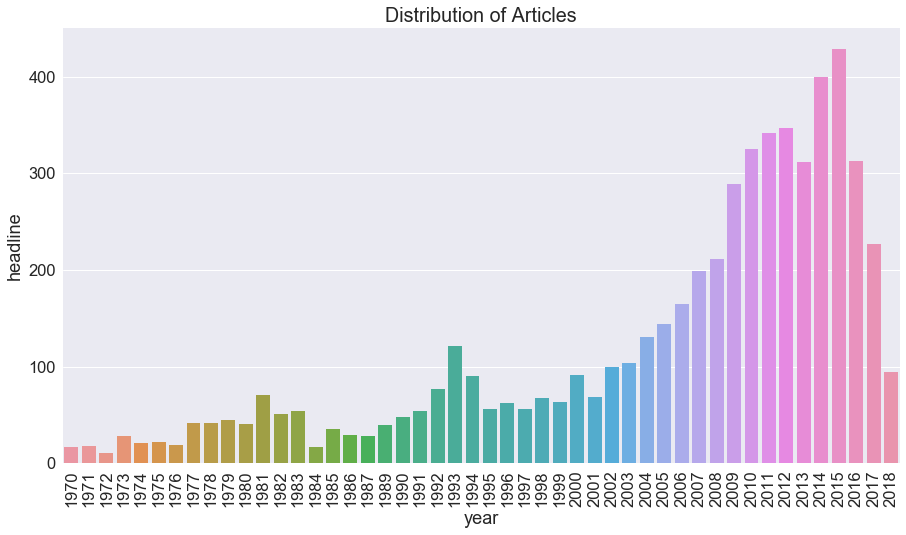

In [1218]:
# look at article distribution over time

sns.set(font_scale=1.65) 
plt.figure(figsize = (15,8))

x = df.groupby('year')['headline'].count().index
y = df.groupby('year')['headline'].count()

p = sns.barplot(x,y)

p.set_xticklabels(x, rotation=90);
p.set_title('Distribution of Articles')

In [911]:
#pickle the final list of articles dataframe

df.to_pickle('df_Final_NYTarticles')

In [9]:
#lets look at the article lengths
article_lengths = df.text.str.len()
article_lengths.head()

0    6842
1    7710
2    7444
3    7610
4    2803
Name: text, dtype: int64

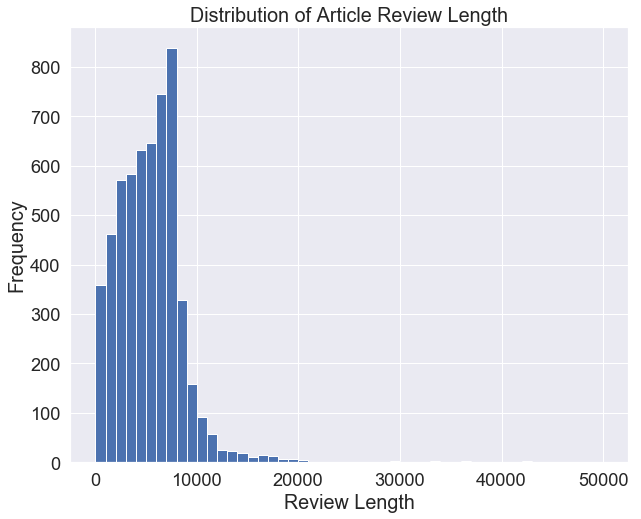

In [10]:
# Histogram of review lengths
sns.set(font_scale=1.65) 
plt.figure(figsize = (10,8))

ax = article_lengths.hist(bins=50)
ax.set(xlabel='Review Length', ylabel='Frequency', 
       title='Distribution of Article Review Length');

## NLP Time

In [11]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer

def custom_tokenizer(text):

    # remove punctuation
    remove_punct = str.maketrans('', '', string.punctuation+'—'+'“'+'”'+'’'+'»'+'â')
    text = text.translate(remove_punct)

    # remove digits and convert to lower case
    remove_digits = str.maketrans('', '', string.digits)
    text = text.lower().translate(remove_digits)

    # tokenize
    tokens = word_tokenize(text)

    # remove stop words
    stop_words = stopwords.words('english')
    tokens_stop = [y for y in tokens if y not in stop_words]
    ret = tokens_stop

    
    #stem
    stemmer = SnowballStemmer('english')
    tokens_stem = [stemmer.stem(y) for y in tokens_stop] 
    ret = tokens_stem

    return ret

In [12]:
corpus = df['text']

In [13]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation

tfidf = TfidfVectorizer(custom_tokenizer)

n_features = 3000
n_top_words = 10
n_components = 12

print("Extracting tf-idf features for NMF...")
tfidf_vectorizer = TfidfVectorizer(max_df=0.40, min_df=5,
                                   max_features=n_features,
                                   analyzer='word',
                                   tokenizer=custom_tokenizer)


tfidf = tfidf_vectorizer.fit_transform(corpus)

nmf = NMF(n_components=n_components, random_state=1,
          alpha=.1, l1_ratio=.5)

nmf_tp = nmf.fit_transform(tfidf)

print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, n_top_words)



Extracting tf-idf features for NMF...

Topics in NMF model (Frobenius norm):
Topic #0: ms famili custom product employe job sale owner sell dont
Topic #1: tax incom rate deduct ir corpor owner pay estat propos
Topic #2: fund investor billion rais privat public stock valuat partner round
Topic #3: bank loan lend credit borrow lender rate financi banker smallbusi
Topic #4: health insur coverag care employe employ premium cost worker benefit
Topic #5: program minor agenc contract govern administr feder sba loan black
Topic #6: site user web facebook app onlin twitter social googl mobil
Topic #7: citi york store street neighborhood mayor space rent manhattan avenu
Topic #8: senat republican bill democrat hous vote legisl clinton committe amend
Topic #9: women ms men femal woman male pao own mrs husband
Topic #10: valley tech technolog silicon capitalist entrepreneur googl investor innov energi
Topic #11: uber lyft kalanick driver ridehail billion car ride taxi china



In [21]:
tp = nmf_tp


In [22]:
# adding the sum and max of total topics here
doc_top = pd.DataFrame(tp)

doc_top['sum'] = doc_top.sum(axis = 1)
doc_top['max'] = np.argmax(tp,axis=1)
doc_top.columns = ['topic_' + str(i) for i in doc_top]

In [23]:
doc_top.head(3)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_sum,topic_max
0,0.131226,0.020346,0.091352,0.000000,0.0,0.104455,0.008583,0.453910,0.000000,0.013052,0.177077,0.000000,1.0,7
1,0.102979,0.012518,0.000000,0.000000,0.0,0.228357,0.000000,0.000000,0.082394,0.000000,0.522509,0.051244,1.0,10
2,0.130203,0.019138,0.537478,0.088914,0.0,0.025971,0.000000,0.030079,0.000000,0.000000,0.103573,0.064644,1.0,2


In [24]:
#normalize all the topics
for i in doc_top.iloc[:,:-2]:
    doc_top[i] = doc_top[i]/doc_top['topic_sum']
    
doc_top.head(3)

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_sum,topic_max
0,0.131226,0.020346,0.091352,0.000000,0.0,0.104455,0.008583,0.453910,0.000000,0.013052,0.177077,0.000000,1.0,7
1,0.102979,0.012518,0.000000,0.000000,0.0,0.228357,0.000000,0.000000,0.082394,0.000000,0.522509,0.051244,1.0,10
2,0.130203,0.019138,0.537478,0.088914,0.0,0.025971,0.000000,0.030079,0.000000,0.000000,0.103573,0.064644,1.0,2


In [25]:
doc_top.rename(columns = {'topic_0':'general_business', 'topic_1':'irs_tax', 'topic_2':'venture_capital',\
                          'topic_3':'bank_loans', 'topic_4':'health_insurance', 'topic_5':'federal_sba', 'topic_6':'social_media', \
                          'topic_7':'nyc_real_estate', 'topic_8':'politics', 'topic_9':'female_entrepreneurs', 'topic_10':'silicon_valley', 'topic_11':'ride_sharing'},\
               inplace = True)

In [26]:
#distribution in terms of max topic per documents

doc_top['topic_max'].value_counts()

0     1937
2      605
10     575
6      504
5      378
7      357
3      317
1      250
4      223
8      200
11     135
9      129
Name: topic_max, dtype: int64

In [27]:
df_topic = df.join(doc_top,how= 'inner')

Text(0.5,1,'Federal SBA Topic Mean Percent Over Time')

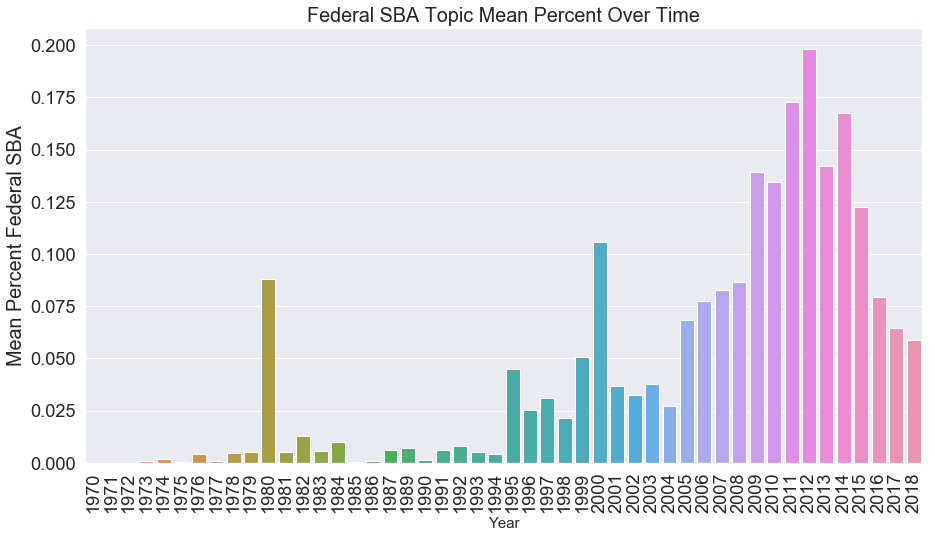

In [28]:
# plot by mean
# Update the topic to see how different topics change over time

sns.set(font_scale=1.65) 
plt.figure(figsize = (15,8))

topic = 'social_media'

x = df_topic.groupby('year')[topic].mean().reset_index()['year']
y = df_topic.groupby('year')[topic].mean().reset_index()[topic]


p = sns.barplot(x,y)
p.set_xticklabels(x, rotation=90);
p.set_xlabel('Year', fontsize = 15)
p.set_ylabel('Mean Percent Federal SBA')
p.set_title('Federal SBA Topic Mean Percent Over Time')

#### Let's group documents by 5 year buckets

In [29]:
def year_group(year):
    if year <= 1975:
        return '1970 - 1975'
    if (year > 1975 and year <= 1980):
        return '1976 - 1980'
    if year > 1980 and year <= 1985:
        return '1980 - 1985'
    if year > 1985 and year <= 1990:
        return '1985 - 1990'
    if year > 1990 and year <= 1995:
        return '1990 - 1995'
    if year > 1995 and year <= 2000:
        return '1995 - 2000'
    if year > 2000 and year <= 2005:
        return '2000 - 2005'
    if year > 2005 and year <= 2010:
        return '2005 - 2010'
    if year > 2010 and year <= 2015:
        return '2010 - 2015'
    if year > 2015 and year <= 2018:
        return '2015 - 2018'

df_topic['5_yr_bucket']=df_topic['year'].apply(year_group)

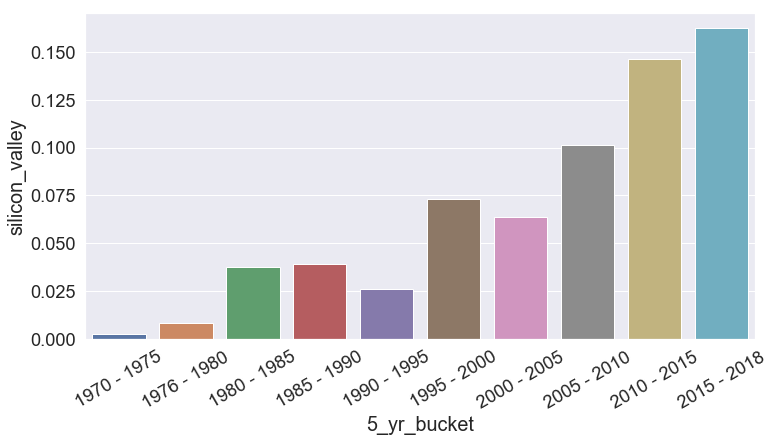

In [30]:
# plot by mean
plt.figure(figsize = (12,6))

topic = 'silicon_valley'

x = df_topic.groupby('5_yr_bucket')[topic].mean().reset_index()['5_yr_bucket']
y = df_topic.groupby('5_yr_bucket')[topic].mean().reset_index()[topic]


p = sns.barplot(x,y)
p.set_xticklabels(x, rotation=30);

## Sentiment Analysis!

In [31]:
#using vader
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [32]:
# getting sentiment on the snippets

analyzer = SentimentIntensityAnalyzer()
def sentiment_analysis(text):
    return analyzer.polarity_scores(text)['compound']
df_topic['sentiment_snippet'] = df_topic['snippet'].apply(sentiment_analysis)

In [33]:
analyzer.polarity_scores(df_topic['snippet'][4])

{'compound': 0.3774, 'neg': 0.0, 'neu': 0.868, 'pos': 0.132}

In [34]:
#running sentiment anlysis on the snippets yielded much better results than running on the actual text

def gen_sentiment(sent_score):
    if sent_score >= 0.05:
        return 'positive'
    if (sent_score > -0.05) and (sent_score < 0.05):
        return 'neutral'
    if sent_score <= -0.05:
        return 'negative'

df_topic['general_sentiment'] = df_topic.sentiment_snippet.apply(gen_sentiment)

In [35]:
df_topic.general_sentiment.value_counts().reset_index()

,index,general_sentiment
0,positive,2941
1,neutral,1405
2,negative,1264


Text(0.5,1,'Number of Articles per General Sentiment')

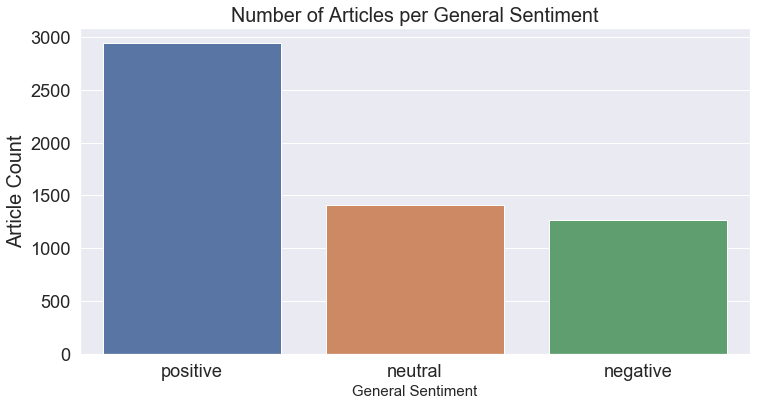

In [36]:
sns.set()
sns.set(font_scale=1.65) 
plt.figure(figsize = (12,6))

x = df_topic.general_sentiment.value_counts().reset_index()['index']
y = df_topic.general_sentiment.value_counts().reset_index()['general_sentiment']
p = sns.barplot(x, y)

# p.set_xticklabels(x, rotation=90);
p.set_xlabel('General Sentiment', fontsize = 15)
p.set_ylabel('Article Count')
p.set_title('Number of Articles per General Sentiment')

Text(0.5,1,'Mean General Sentiment Over Time')

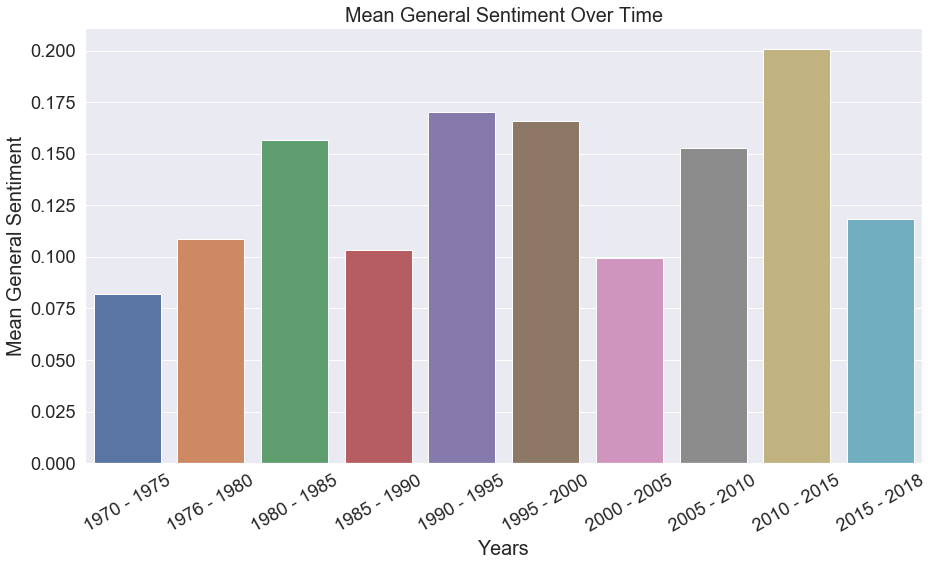

In [40]:
#plot by sentiment mean over year

import seaborn as sns

plt.figure(figsize = (15,8))

# topic = 'topic_4'

x = df_topic.groupby('5_yr_bucket')['sentiment_snippet'].mean().reset_index()['5_yr_bucket']
y = df_topic.groupby('5_yr_bucket')['sentiment_snippet'].mean().reset_index()['sentiment_snippet']


p = sns.barplot(x,y)
p.set_xticklabels(x, rotation=30);


p.set_xlabel('Years')
p.set_ylabel('Mean General Sentiment')
p.set_title('Mean General Sentiment Over Time')

# looking at one of the charts further below, there's too much noise to make actual conclusions on this chart

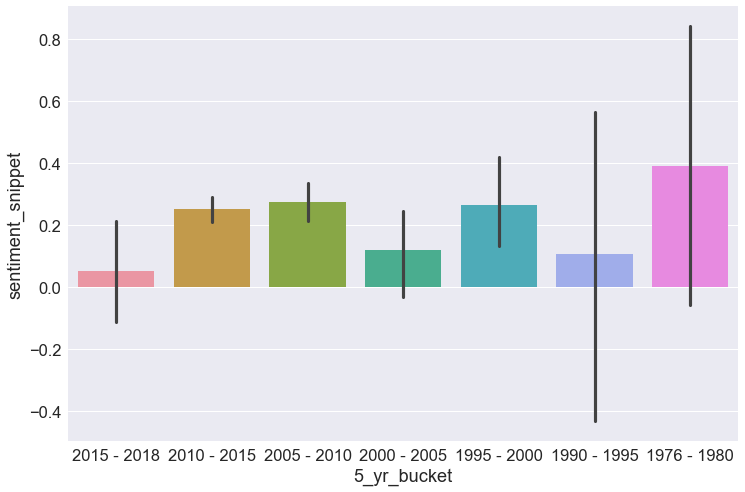

In [1251]:
# plot by sentiment mean over year PER MAX TOPIC
plt.figure(figsize = (12,8))
max_topic_n = 6

p = sns.barplot(x= '5_yr_bucket',y = 'sentiment_snippet', data = df_topic[df_topic['topic_max'] == max_topic_n])

# p.set_xticklabels(x, rotation=90);

# t-SNE PLOT

In [1098]:
#defining topics so I can reference from here in the plot below
topics = ['general_business', 'irs_tax', 'venture_capital', 'bank_loans', 'health_insurance', 'sba', 'social_media',\
          'nyc_real_estate', 'politics', 'female_entrepreneurs', 'silicon_valley', 'ride_sharing']

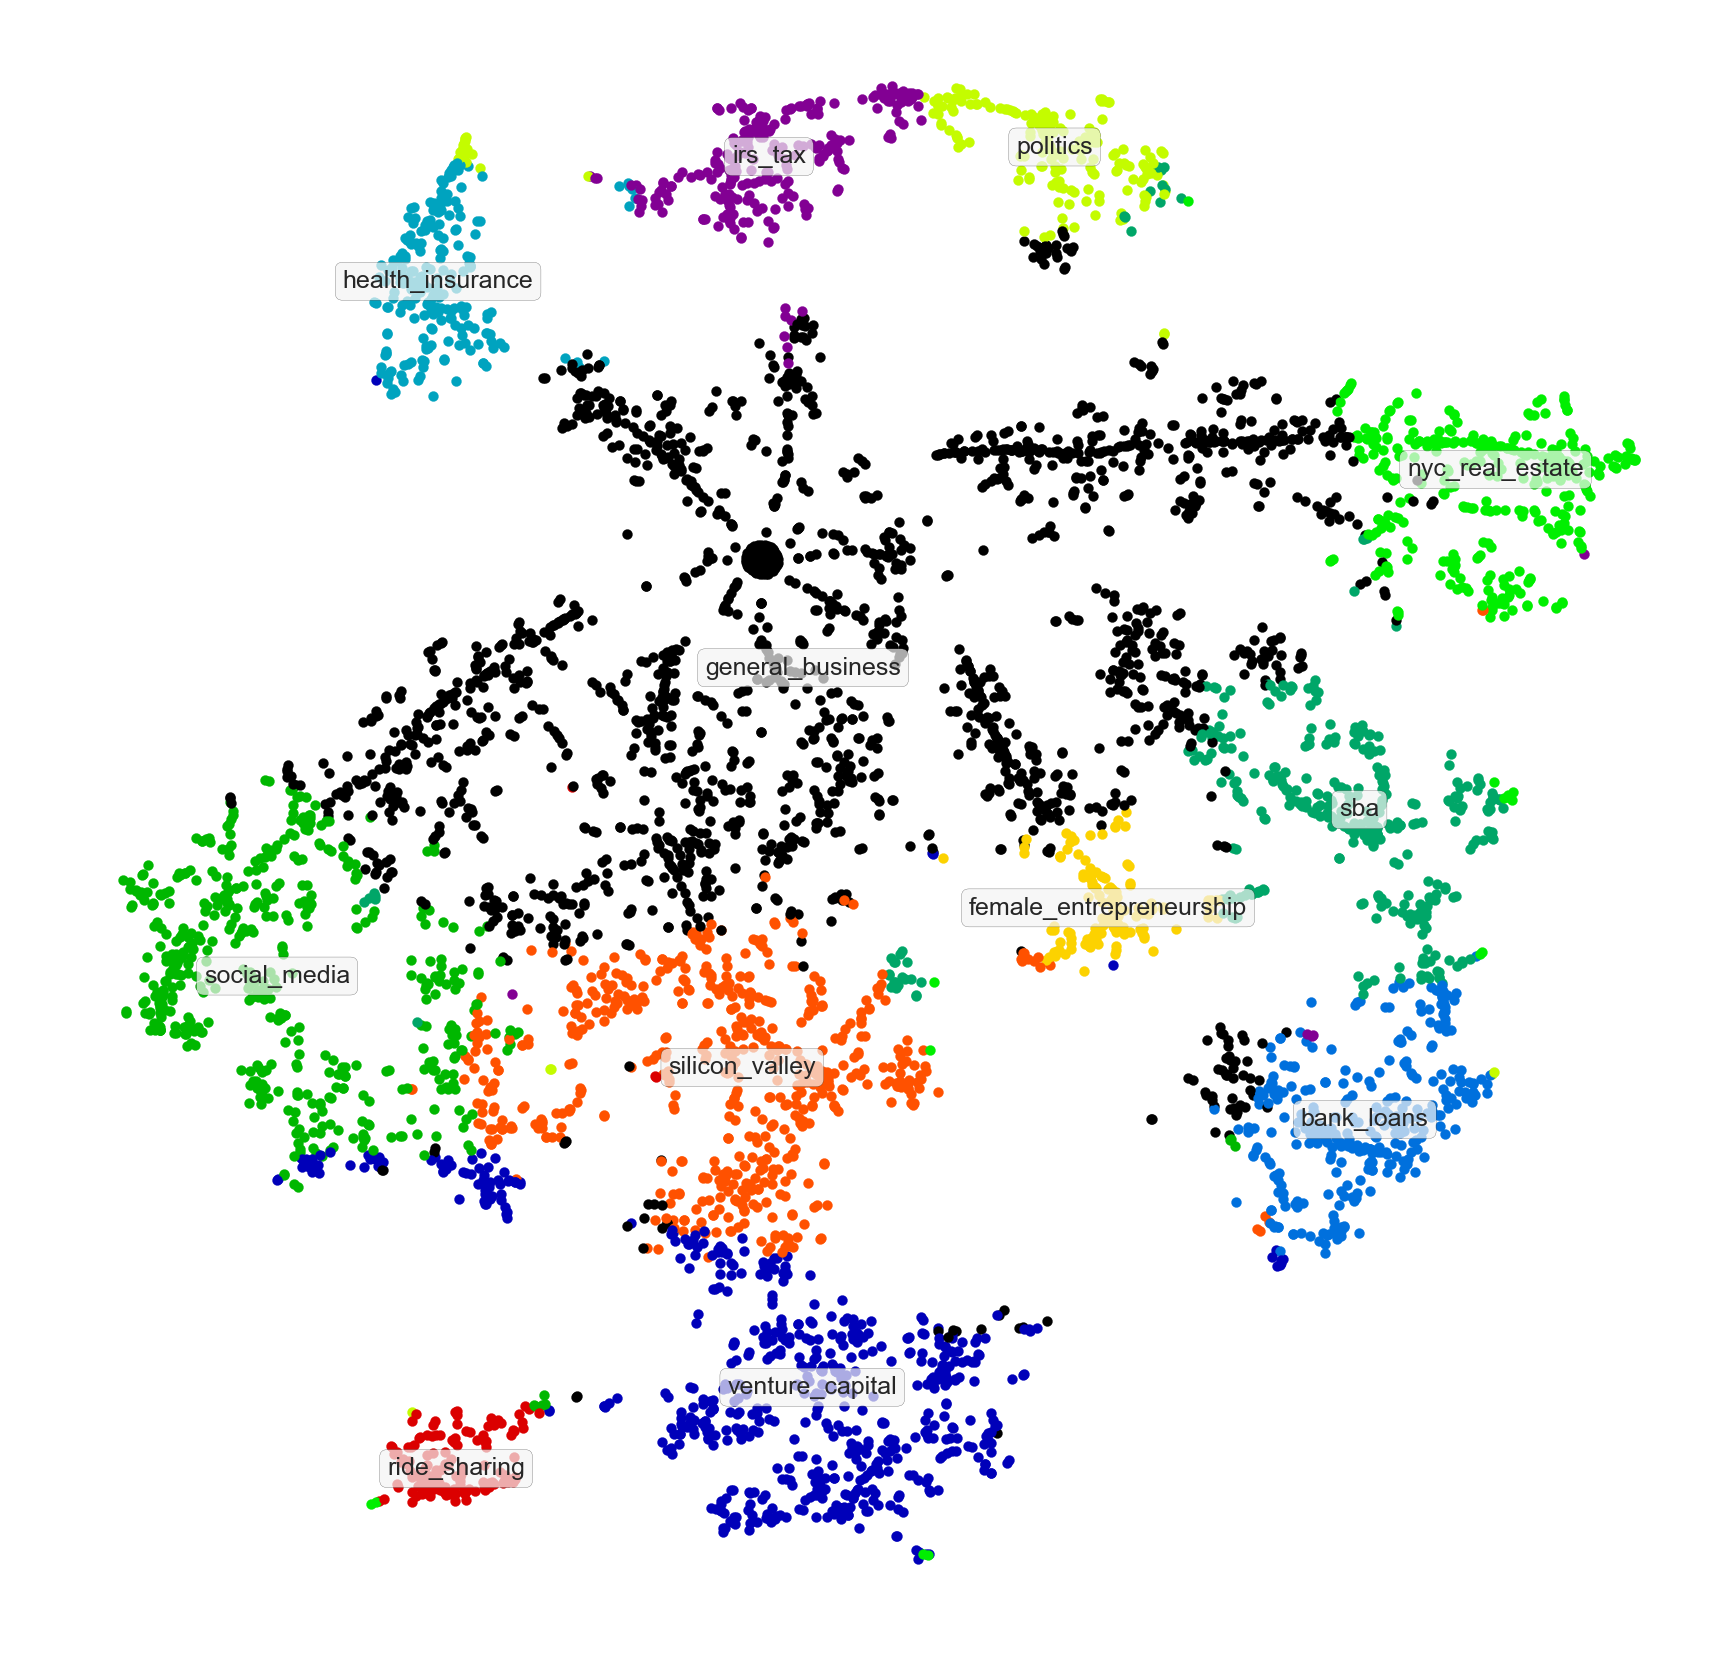

In [1181]:
from sklearn.manifold import TSNE
import matplotlib.patches as mpatches

plt.figure(figsize = (15,8))

tokens=tp[:,:]
new_values = TSNE(metric='cosine',perplexity=40, n_components=2).fit_transform(tokens)
x = []
y = []
labels = []
num_topics = len(tokens[0])
for value in new_values:
    x.append(value[0])
    y.append(value[1])

cmap = matplotlib.cm.get_cmap('nipy_spectral')
cmapScale = int(cmap.N / num_topics)
plt.figure(figsize=(30, 30),facecolor='white')
labels = [] 
for i in range(len(x)):
    label = np.argmax(tokens[i])
    labels.append(label)
    plt.scatter(x[i],y[i], c=cmap(label*cmapScale),s=100)

color_legend = []
for i in range(num_topics):
    boolArr = np.array(labels) == i
    x_avg = np.median(np.array(x)[boolArr])
    y_avg = np.median(np.array(y)[boolArr])
    plt.annotate(topics[i],
                 xy=(x_avg, y_avg),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='center',
                 va='center',
                 fontsize=25,
                 bbox=dict(boxstyle="round", fc="whitesmoke",alpha=0.7))
    color_legend.append(mpatches.Patch(color=cmap(i*cmapScale), label=f'Topic #{i+1}: {topics[i]}'))
# plt.legend(handles=color_legend,fontsize=18)
plt.axis('off')
plt.show()

The plot definitely hints to more seperability, and future steps would look into that.